# Model Hyperparameter Tuning

In [1]:
# ============================================================================
# SETUP & IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from scipy.special import expit
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

print("="*80)
print("🔧 HYPERPARAMETER TUNING - SHIP VOYAGE DELAY PREDICTION")
print("="*80)
print(f"   Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Approach: Randomized Search → Grid Search Refinement")

🔧 HYPERPARAMETER TUNING - SHIP VOYAGE DELAY PREDICTION
   Started: 2025-12-24 06:08:28
   Approach: Randomized Search → Grid Search Refinement


In [2]:
# ============================================================================
# LOAD DATA & BASELINE MODELS
# ============================================================================

print("\n" + "="*80)
print("STEP 1: LOADING DATA & BASELINE MODELS")
print("="*80)

# Load datasets
print("\n📂 Loading datasets...")
train_df = pd.read_csv('train_2020_2023.csv', parse_dates=['StartTime', 'EndTime'])
test_df = pd.read_csv('test_2024.csv', parse_dates=['StartTime', 'EndTime'])

print(f"   ✅ Training data: {len(train_df):,} rows")
print(f"   ✅ Test data: {len(test_df):,} rows")

# Load scaler
print("\n🔧 Loading scaler...")
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("   ✅ Scaler loaded")

# Prepare features (same as training notebook)
print("\n📊 Preparing features...")
exclude_cols = [
    'IsDelayed', 'DelayHours', 'DelayPercentage', 'DurationDifference',
    'MMSI', 'IMO', 'VesselName', 'StartTime', 'EndTime',
    'DurationHours', 'AverageSpeedKMH', 'TotalDistanceKM', 'AverageCOG',
    'ExpectedDuration', 'StartLatitude', 'StartLongitude',
    'EndLatitude', 'EndLongitude',
]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X_train_full = train_df[feature_cols].copy()
y_class_train_full = train_df['IsDelayed'].copy()
y_reg_train_full = train_df['DelayHours'].copy()

X_test = test_df[feature_cols].copy()
y_class_test = test_df['IsDelayed'].copy()
y_reg_test = test_df['DelayHours'].copy()

# Scale features
X_train_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(f"   ✅ Features prepared: {len(feature_cols)} columns")

# Load baseline models
print("\n📦 Loading baseline models...")
baseline_models = {}

try:
    with open('model_rf_classification.pkl', 'rb') as f:
        baseline_models['RF_Classifier'] = pickle.load(f)
    with open('model_xgb_classification.pkl', 'rb') as f:
        baseline_models['XGB_Classifier'] = pickle.load(f)
    with open('model_rfr_regression.pkl', 'rb') as f:
        baseline_models['RF_Regressor'] = pickle.load(f)
    with open('model_xgbr_regression.pkl', 'rb') as f:
        baseline_models['XGB_Regressor'] = pickle.load(f)
    print("   ✅ All baseline models loaded")
except FileNotFoundError as e:
    print(f"   ⚠️  Warning: {e}")

# Load baseline performance
classification_results = pd.read_csv('classification_results.csv', index_col=0)
regression_results = pd.read_csv('regression_results.csv', index_col=0)
    
baseline_scores = {
    'RF_Classifier': {
        'test_accuracy': classification_results.loc['Random Forest', 'test_accuracy'],
        'test_f1': classification_results.loc['Random Forest', 'test_f1'],
        'test_recall': classification_results.loc['Random Forest', 'test_recall'],
        'test_roc_auc': classification_results.loc['Random Forest', 'test_roc_auc']
    },
    'XGB_Classifier': {
        'test_accuracy': classification_results.loc['XGBoost', 'test_accuracy'],
        'test_f1': classification_results.loc['XGBoost', 'test_f1'],
        'test_recall': classification_results.loc['XGBoost', 'test_recall'],
        'test_roc_auc': classification_results.loc['XGBoost', 'test_roc_auc']
    },
    'RF_Regressor': {
        'test_mae': regression_results.loc['Random Forest', 'test_mae'],
        'test_rmse': regression_results.loc['Random Forest', 'test_rmse'],
        'test_r2': regression_results.loc['Random Forest', 'test_r2']
    },
    'XGB_Regressor': {
        'test_mae': regression_results.loc['XGBoost', 'test_mae'],
        'test_rmse': regression_results.loc['XGBoost', 'test_rmse'],
        'test_r2': regression_results.loc['XGBoost', 'test_r2']
    }
}

print("\n📊 BASELINE PERFORMANCE SUMMARY:")
print("\n   CLASSIFICATION:")
print(f"      Random Forest:  Acc={baseline_scores['RF_Classifier']['test_accuracy']:.4f}, "
      f"F1={baseline_scores['RF_Classifier']['test_f1']:.4f}, "
      f"Recall={baseline_scores['RF_Classifier']['test_recall']:.4f}")
print(f"      XGBoost:        Acc={baseline_scores['XGB_Classifier']['test_accuracy']:.4f}, "
      f"F1={baseline_scores['XGB_Classifier']['test_f1']:.4f}, "
      f"Recall={baseline_scores['XGB_Classifier']['test_recall']:.4f}")

print("\n   REGRESSION:")
print(f"      Random Forest:  MAE={baseline_scores['RF_Regressor']['test_mae']:.2f}h, "
      f"RMSE={baseline_scores['RF_Regressor']['test_rmse']:.2f}h, "
      f"R²={baseline_scores['RF_Regressor']['test_r2']:.4f}")
print(f"      XGBoost:        MAE={baseline_scores['XGB_Regressor']['test_mae']:.2f}h, "
      f"RMSE={baseline_scores['XGB_Regressor']['test_rmse']:.2f}h, "
      f"R²={baseline_scores['XGB_Regressor']['test_r2']:.4f}")

print("\n✅ Ready for hyperparameter tuning!")


STEP 1: LOADING DATA & BASELINE MODELS

📂 Loading datasets...
   ✅ Training data: 1,308,221 rows
   ✅ Test data: 367,077 rows

🔧 Loading scaler...
   ✅ Scaler loaded

📊 Preparing features...
   ✅ Features prepared: 31 columns

📦 Loading baseline models...
   ✅ All baseline models loaded

📊 BASELINE PERFORMANCE SUMMARY:

   CLASSIFICATION:
      Random Forest:  Acc=0.8834, F1=0.7830, Recall=0.8386
      XGBoost:        Acc=0.8757, F1=0.7005, Recall=0.5796

   REGRESSION:
      Random Forest:  MAE=58.79h, RMSE=92.12h, R²=0.8787
      XGBoost:        MAE=67.48h, RMSE=97.37h, R²=0.8645

✅ Ready for hyperparameter tuning!


In [3]:
# ============================================================================
# TUNE: RANDOM FOREST CLASSIFIER
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("="*80)

# Define parameter space
rf_clf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_samples': [0.7, 0.8, 0.9],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("\n🔍 PHASE 1: Randomized Search (20 iterations)")
print(f"   Parameter space size: {np.prod([len(v) for v in rf_clf_params.values()]):,} combinations")
print(f"   Testing: 20 random combinations")

start_time = time.time()

rf_clf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_clf_params,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"\n   ⏳ Training started at {datetime.now().strftime('%H:%M:%S')}...")
rf_clf_random.fit(X_train_scaled, y_class_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Randomized search completed in {elapsed/60:.1f} minutes")
print(f"\n   🏆 Best CV F1-Score: {rf_clf_random.best_score_:.4f}")
print(f"   📋 Best parameters:")
for param, value in rf_clf_random.best_params_.items():
    print(f"      {param}: {value}")

# PHASE 2: Grid Search Refinement
print("\n🔍 PHASE 2: Grid Search Refinement")

best_params = rf_clf_random.best_params_

# Create refined grid around best parameters
rf_clf_refined = {
    'n_estimators': [best_params['n_estimators'], 
                     min(500, best_params['n_estimators']+50)],
    'max_depth': [best_params['max_depth']] if best_params['max_depth'] is None 
                 else [best_params['max_depth'], 
                       best_params['max_depth']+2],
    'min_samples_split': [best_params['min_samples_split']],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'max_features': [best_params['max_features']],
    'max_samples': [best_params['max_samples']],
    'class_weight': [best_params['class_weight']]
}

grid_size = np.prod([len(v) for v in rf_clf_refined.values()])
print(f"   Refined grid: {grid_size} combinations x 3 CV = {grid_size*3} fits")
print(f"   ⏱️  Estimated time: {grid_size*3*2:.0f}-{grid_size*3*3:.0f} minutes")

start_time = time.time()
rf_clf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_clf_refined,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print(f"   ⏳ Grid search started at {datetime.now().strftime('%H:%M:%S')}...")
rf_clf_grid.fit(X_train_scaled, y_class_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Grid search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV F1-Score: {rf_clf_grid.best_score_:.4f}")

# Evaluate on test set
print("\n📊 EVALUATING ON TEST SET:")
rf_clf_tuned = rf_clf_grid.best_estimator_
rf_clf_test_pred = rf_clf_tuned.predict(X_test_scaled)
rf_clf_test_proba = rf_clf_tuned.predict_proba(X_test_scaled)[:, 1]

tuned_acc = accuracy_score(y_class_test, rf_clf_test_pred)
tuned_f1 = f1_score(y_class_test, rf_clf_test_pred)
tuned_recall = recall_score(y_class_test, rf_clf_test_pred)
tuned_roc = roc_auc_score(y_class_test, rf_clf_test_proba)

print(f"\n   BASELINE:")
print(f"      Accuracy: {baseline_scores['RF_Classifier']['test_accuracy']:.4f}")
print(f"      F1-Score: {baseline_scores['RF_Classifier']['test_f1']:.4f}")
print(f"      Recall:   {baseline_scores['RF_Classifier']['test_recall']:.4f}")
print(f"      ROC-AUC:  {baseline_scores['RF_Classifier']['test_roc_auc']:.4f}")

print(f"\n   TUNED:")
print(f"      Accuracy: {tuned_acc:.4f} ({(tuned_acc-baseline_scores['RF_Classifier']['test_accuracy'])*100:+.2f}%)")
print(f"      F1-Score: {tuned_f1:.4f} ({(tuned_f1-baseline_scores['RF_Classifier']['test_f1'])*100:+.2f}%)")
print(f"      Recall:   {tuned_recall:.4f} ({(tuned_recall-baseline_scores['RF_Classifier']['test_recall'])*100:+.2f}%)")
print(f"      ROC-AUC:  {tuned_roc:.4f} ({(tuned_roc-baseline_scores['RF_Classifier']['test_roc_auc'])*100:+.2f}%)")

# Confusion matrix
cm = confusion_matrix(y_class_test, rf_clf_test_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\n   CONFUSION MATRIX:")
print(f"      TN={tn:,} | FP={fp:,}")
print(f"      FN={fn:,} | TP={tp:,}")
print(f"      False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"      False Negative Rate: {fn/(fn+tp)*100:.2f}%")

# Save tuned model
with open('model_rf_classification_tuned.pkl', 'wb') as f:
    pickle.dump(rf_clf_tuned, f)
print(f"\n💾 Tuned model saved: model_rf_classification_tuned.pkl")

# Store results
rf_clf_results = {
    'model': 'Random Forest Classifier',
    'best_params': rf_clf_grid.best_params_,
    'cv_f1': rf_clf_grid.best_score_,
    'test_accuracy': tuned_acc,
    'test_f1': tuned_f1,
    'test_recall': tuned_recall,
    'test_roc_auc': tuned_roc,
    'improvement_f1': (tuned_f1 - baseline_scores['RF_Classifier']['test_f1']) * 100
}


MODEL 1: RANDOM FOREST CLASSIFIER

🔍 PHASE 1: Randomized Search (20 iterations)
   Parameter space size: 4,320 combinations
   Testing: 20 random combinations

   ⏳ Training started at 06:08:42...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Randomized search completed in 146.3 minutes

   🏆 Best CV F1-Score: 0.8049
   📋 Best parameters:
      n_estimators: 200
      min_samples_split: 10
      min_samples_leaf: 2
      max_samples: 0.9
      max_features: 0.5
      max_depth: 10
      class_weight: balanced_subsample

🔍 PHASE 2: Grid Search Refinement
   Refined grid: 4 combinations x 3 CV = 12 fits
   ⏱️  Estimated time: 24-36 minutes
   ⏳ Grid search started at 08:34:58...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

   ✅ Grid search completed in 72.3 minutes
   🏆 Best CV F1-Score: 0.8081

📊 EVALUATING ON TEST SET:

   BASELINE:
      Accuracy: 0.8834
      F1-Score: 0.7830
      Recall:   0.8386
      ROC-AUC:  0.9509

   TUNED:
      Accuracy

In [4]:
# ============================================================================
# TUNE: XGBOOST CLASSIFIER
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBOOST CLASSIFIER")
print("="*80)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_class_train_full),
                                     y=y_class_train_full)
scale_pos_weight = class_weights[0] / class_weights[1]

# Define parameter space
xgb_clf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [scale_pos_weight * 0.8, scale_pos_weight, scale_pos_weight * 1.2]
}

print("\n🔍 PHASE 1: Randomized Search (20 iterations)")
print(f"   Parameter space size: {np.prod([len(v) for v in xgb_clf_params.values()]):,} combinations")

start_time = time.time()

xgb_clf_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_distributions=xgb_clf_params,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"   ⏳ Training started at {datetime.now().strftime('%H:%M:%S')}...")
xgb_clf_random.fit(X_train_scaled, y_class_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Randomized search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV F1-Score: {xgb_clf_random.best_score_:.4f}")
print(f"   📋 Best parameters:")
for param, value in xgb_clf_random.best_params_.items():
    print(f"      {param}: {value}")

# PHASE 2: Grid Search Refinement
print("\n🔍 PHASE 2: Grid Search Refinement")

best_params = xgb_clf_random.best_params_

xgb_clf_refined = {
    'n_estimators': [best_params['n_estimators'], 
                     min(500, best_params['n_estimators']+50)],
    'max_depth': [best_params['max_depth'], 
                  best_params['max_depth']+1],
    'learning_rate': [best_params['learning_rate']],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']],
    'gamma': [best_params['gamma']],
    'min_child_weight': [best_params['min_child_weight']],
    'scale_pos_weight': [best_params['scale_pos_weight']]
}

grid_size = np.prod([len(v) for v in xgb_clf_refined.values()])
print(f"   Refined grid: {grid_size} combinations x 3 CV = {grid_size*3} fits")
print(f"   ⏱️  Estimated time: {grid_size*3*2:.0f}-{grid_size*3*3:.0f} minutes")

start_time = time.time()
xgb_clf_grid = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid=xgb_clf_refined,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print(f"   ⏳ Grid search started at {datetime.now().strftime('%H:%M:%S')}...")
xgb_clf_grid.fit(X_train_scaled, y_class_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Grid search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV F1-Score: {xgb_clf_grid.best_score_:.4f}")

# Evaluate on test set
print("\n📊 EVALUATING ON TEST SET:")
xgb_clf_tuned = xgb_clf_grid.best_estimator_
xgb_clf_test_pred = xgb_clf_tuned.predict(X_test_scaled)
xgb_clf_test_proba = xgb_clf_tuned.predict_proba(X_test_scaled)[:, 1]

tuned_acc = accuracy_score(y_class_test, xgb_clf_test_pred)
tuned_f1 = f1_score(y_class_test, xgb_clf_test_pred)
tuned_recall = recall_score(y_class_test, xgb_clf_test_pred)
tuned_roc = roc_auc_score(y_class_test, xgb_clf_test_proba)

print(f"\n   BASELINE:")
print(f"      Accuracy: {baseline_scores['XGB_Classifier']['test_accuracy']:.4f}")
print(f"      F1-Score: {baseline_scores['XGB_Classifier']['test_f1']:.4f}")
print(f"      Recall:   {baseline_scores['XGB_Classifier']['test_recall']:.4f}")
print(f"      ROC-AUC:  {baseline_scores['XGB_Classifier']['test_roc_auc']:.4f}")

print(f"\n   TUNED:")
print(f"      Accuracy: {tuned_acc:.4f} ({(tuned_acc-baseline_scores['XGB_Classifier']['test_accuracy'])*100:+.2f}%)")
print(f"      F1-Score: {tuned_f1:.4f} ({(tuned_f1-baseline_scores['XGB_Classifier']['test_f1'])*100:+.2f}%)")
print(f"      Recall:   {tuned_recall:.4f} ({(tuned_recall-baseline_scores['XGB_Classifier']['test_recall'])*100:+.2f}%)")
print(f"      ROC-AUC:  {tuned_roc:.4f} ({(tuned_roc-baseline_scores['XGB_Classifier']['test_roc_auc'])*100:+.2f}%)")

# Confusion matrix
cm = confusion_matrix(y_class_test, xgb_clf_test_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\n   CONFUSION MATRIX:")
print(f"      TN={tn:,} | FP={fp:,}")
print(f"      FN={fn:,} | TP={tp:,}")
print(f"      False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"      False Negative Rate: {fn/(fn+tp)*100:.2f}%")

# Save tuned model
with open('model_xgb_classification_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_clf_tuned, f)
print(f"\n💾 Tuned model saved: model_xgb_classification_tuned.pkl")

# Store results
xgb_clf_results = {
    'model': 'XGBoost Classifier',
    'best_params': xgb_clf_grid.best_params_,
    'cv_f1': xgb_clf_grid.best_score_,
    'test_accuracy': tuned_acc,
    'test_f1': tuned_f1,
    'test_recall': tuned_recall,
    'test_roc_auc': tuned_roc,
    'improvement_f1': (tuned_f1 - baseline_scores['XGB_Classifier']['test_f1']) * 100
}


MODEL 2: XGBOOST CLASSIFIER

🔍 PHASE 1: Randomized Search (20 iterations)
   Parameter space size: 20,736 combinations
   ⏳ Training started at 09:47:24...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Randomized search completed in 7.8 minutes
   🏆 Best CV F1-Score: 0.7385
   📋 Best parameters:
      subsample: 0.6
      scale_pos_weight: 0.34093443651317545
      n_estimators: 100
      min_child_weight: 5
      max_depth: 7
      learning_rate: 0.2
      gamma: 0.5
      colsample_bytree: 0.8

🔍 PHASE 2: Grid Search Refinement
   Refined grid: 4 combinations x 3 CV = 12 fits
   ⏱️  Estimated time: 24-36 minutes
   ⏳ Grid search started at 09:55:12...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

   ✅ Grid search completed in 1.7 minutes
   🏆 Best CV F1-Score: 0.7385

📊 EVALUATING ON TEST SET:

   BASELINE:
      Accuracy: 0.8757
      F1-Score: 0.7005
      Recall:   0.5796
      ROC-AUC:  0.9581

   TUNED:
      Accuracy: 0.8646 (-1.11%)
      F

In [5]:
# ============================================================================
# TUNE: RANDOM FOREST REGRESSOR
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*80)

# Define parameter space
rf_reg_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5, 0.7, 1.0],
    'max_samples': [0.7, 0.8, 0.9]
}

print("\n🔍 PHASE 1: Randomized Search (20 iterations)")
print(f"   Parameter space size: {np.prod([len(v) for v in rf_reg_params.values()]):,} combinations")

start_time = time.time()

rf_reg_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_reg_params,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"   ⏳ Training started at {datetime.now().strftime('%H:%M:%S')}...")
rf_reg_random.fit(X_train_scaled, y_reg_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Randomized search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV MAE: {-rf_reg_random.best_score_:.2f} hours")
print(f"   📋 Best parameters:")
for param, value in rf_reg_random.best_params_.items():
    print(f"      {param}: {value}")

# PHASE 2: Grid Search Refinement
print("\n🔍 PHASE 2: Grid Search Refinement")

best_params = rf_reg_random.best_params_

rf_reg_refined = {
    'n_estimators': [best_params['n_estimators'], 
                     best_params['n_estimators']+50],
    'max_depth': [best_params['max_depth'], 
                  best_params['max_depth']+3],
    'min_samples_split': [best_params['min_samples_split']],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'max_features': [best_params['max_features']],
    'max_samples': [best_params['max_samples']]
}

grid_size = np.prod([len(v) for v in rf_reg_refined.values()])
print(f"   Refined grid: {grid_size} combinations x 3 CV = {grid_size*3} fits")
print(f"   ⏱️  Estimated time: {grid_size*3*2:.0f}-{grid_size*3*3:.0f} minutes")

start_time = time.time()
rf_reg_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_reg_refined,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

print(f"   ⏳ Grid search started at {datetime.now().strftime('%H:%M:%S')}...")
rf_reg_grid.fit(X_train_scaled, y_reg_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Grid search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV MAE: {-rf_reg_grid.best_score_:.2f} hours")

# Evaluate on test set
print("\n📊 EVALUATING ON TEST SET:")
rf_reg_tuned = rf_reg_grid.best_estimator_
rf_reg_test_pred = rf_reg_tuned.predict(X_test_scaled)

tuned_mae = mean_absolute_error(y_reg_test, rf_reg_test_pred)
tuned_rmse = np.sqrt(mean_squared_error(y_reg_test, rf_reg_test_pred))
tuned_r2 = r2_score(y_reg_test, rf_reg_test_pred)

print(f"\n   BASELINE:")
print(f"      MAE:  {baseline_scores['RF_Regressor']['test_mae']:.2f} hours")
print(f"      RMSE: {baseline_scores['RF_Regressor']['test_rmse']:.2f} hours")
print(f"      R²:   {baseline_scores['RF_Regressor']['test_r2']:.4f}")

print(f"\n   TUNED:")
print(f"      MAE:  {tuned_mae:.2f} hours ({tuned_mae-baseline_scores['RF_Regressor']['test_mae']:+.2f}h)")
print(f"      RMSE: {tuned_rmse:.2f} hours ({tuned_rmse-baseline_scores['RF_Regressor']['test_rmse']:+.2f}h)")
print(f"      R²:   {tuned_r2:.4f} ({(tuned_r2-baseline_scores['RF_Regressor']['test_r2'])*100:+.2f}%)")

# Additional metrics
print(f"\n   PREDICTION QUALITY:")
print(f"      Mean Error: {np.mean(rf_reg_test_pred - y_reg_test):.2f} hours")
print(f"      Median Error: {np.median(np.abs(rf_reg_test_pred - y_reg_test)):.2f} hours")
print(f"      90th Percentile Error: {np.percentile(np.abs(rf_reg_test_pred - y_reg_test), 90):.2f} hours")

# Save tuned model
with open('model_rfr_regression_tuned.pkl', 'wb') as f:
    pickle.dump(rf_reg_tuned, f)
print(f"\n💾 Tuned model saved: model_rfr_regression_tuned.pkl")

# Store results
rf_reg_results = {
    'model': 'Random Forest Regressor',
    'best_params': rf_reg_grid.best_params_,
    'cv_mae': -rf_reg_grid.best_score_,
    'test_mae': tuned_mae,
    'test_rmse': tuned_rmse,
    'test_r2': tuned_r2,
    'improvement_mae': baseline_scores['RF_Regressor']['test_mae'] - tuned_mae
}


MODEL 3: RANDOM FOREST REGRESSOR

🔍 PHASE 1: Randomized Search (20 iterations)
   Parameter space size: 2,160 combinations
   ⏳ Training started at 09:56:57...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Randomized search completed in 419.5 minutes
   🏆 Best CV MAE: 63.78 hours
   📋 Best parameters:
      n_estimators: 300
      min_samples_split: 10
      min_samples_leaf: 4
      max_samples: 0.9
      max_features: 0.7
      max_depth: 15

🔍 PHASE 2: Grid Search Refinement
   Refined grid: 4 combinations x 3 CV = 12 fits
   ⏱️  Estimated time: 24-36 minutes
   ⏳ Grid search started at 16:56:28...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

   ✅ Grid search completed in 146.9 minutes
   🏆 Best CV MAE: 63.76 hours

📊 EVALUATING ON TEST SET:

   BASELINE:
      MAE:  58.79 hours
      RMSE: 92.12 hours
      R²:   0.8787

   TUNED:
      MAE:  57.42 hours (-1.37h)
      RMSE: 88.60 hours (-3.52h)
      R²:   0.8878 (+0.91%)

   PREDICTION QUALIT

In [6]:
# ============================================================================
# TUNE: XGBOOST REGRESSOR
# ============================================================================

print("\n" + "="*80)
print("MODEL 4: XGBOOST REGRESSOR")
print("="*80)

# Define parameter space
xgb_reg_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5]
}

print("\n🔍 PHASE 1: Randomized Search (20 iterations)")
print(f"   Parameter space size: {np.prod([len(v) for v in xgb_reg_params.values()]):,} combinations")

start_time = time.time()

xgb_reg_random = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=xgb_reg_params,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"   ⏳ Training started at {datetime.now().strftime('%H:%M:%S')}...")
xgb_reg_random.fit(X_train_scaled, y_reg_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Randomized search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV MAE: {-xgb_reg_random.best_score_:.2f} hours")
print(f"   📋 Best parameters:")
for param, value in xgb_reg_random.best_params_.items():
    print(f"      {param}: {value}")

# PHASE 2: Grid Search Refinement
print("\n🔍 PHASE 2: Grid Search Refinement")

best_params = xgb_reg_random.best_params_

xgb_reg_refined = {
    'n_estimators': [best_params['n_estimators'], 
                     min(500, best_params['n_estimators']+50)],
    'max_depth': [best_params['max_depth'], 
                  best_params['max_depth']+1],
    'learning_rate': [best_params['learning_rate']],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']],
    'gamma': [best_params['gamma']],
    'min_child_weight': [best_params['min_child_weight']],
    'reg_alpha': [best_params['reg_alpha']],
    'reg_lambda': [best_params['reg_lambda']]
}

grid_size = np.prod([len(v) for v in xgb_reg_refined.values()])
print(f"   Refined grid: {grid_size} combinations x 3 CV = {grid_size*3} fits")
print(f"   ⏱️  Estimated time: {grid_size*3*2:.0f}-{grid_size*3*3:.0f} minutes")

start_time = time.time()
xgb_reg_grid = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=xgb_reg_refined,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

print(f"   ⏳ Grid search started at {datetime.now().strftime('%H:%M:%S')}...")
xgb_reg_grid.fit(X_train_scaled, y_reg_train_full)

elapsed = time.time() - start_time
print(f"\n   ✅ Grid search completed in {elapsed/60:.1f} minutes")
print(f"   🏆 Best CV MAE: {-xgb_reg_grid.best_score_:.2f} hours")

# Evaluate on test set
print("\n📊 EVALUATING ON TEST SET:")
xgb_reg_tuned = xgb_reg_grid.best_estimator_
xgb_reg_test_pred = xgb_reg_tuned.predict(X_test_scaled)

tuned_mae = mean_absolute_error(y_reg_test, xgb_reg_test_pred)
tuned_rmse = np.sqrt(mean_squared_error(y_reg_test, xgb_reg_test_pred))
tuned_r2 = r2_score(y_reg_test, xgb_reg_test_pred)

print(f"\n   BASELINE:")
print(f"      MAE:  {baseline_scores['XGB_Regressor']['test_mae']:.2f} hours")
print(f"      RMSE: {baseline_scores['XGB_Regressor']['test_rmse']:.2f} hours")
print(f"      R²:   {baseline_scores['XGB_Regressor']['test_r2']:.4f}")

print(f"\n   TUNED:")
print(f"      MAE:  {tuned_mae:.2f} hours ({tuned_mae-baseline_scores['XGB_Regressor']['test_mae']:+.2f}h)")
print(f"      RMSE: {tuned_rmse:.2f} hours ({tuned_rmse-baseline_scores['XGB_Regressor']['test_rmse']:+.2f}h)")
print(f"      R²:   {tuned_r2:.4f} ({(tuned_r2-baseline_scores['XGB_Regressor']['test_r2'])*100:+.2f}%)")

# Additional metrics
print(f"\n   PREDICTION QUALITY:")
print(f"      Mean Error: {np.mean(xgb_reg_test_pred - y_reg_test):.2f} hours")
print(f"      Median Error: {np.median(np.abs(xgb_reg_test_pred - y_reg_test)):.2f} hours")
print(f"      90th Percentile Error: {np.percentile(np.abs(xgb_reg_test_pred - y_reg_test), 90):.2f} hours")

# Save tuned model
with open('model_xgbr_regression_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_reg_tuned, f)
print(f"\n💾 Tuned model saved: model_xgbr_regression_tuned.pkl")

# Store results
xgb_reg_results = {
    'model': 'XGBoost Regressor',
    'best_params': xgb_reg_grid.best_params_,
    'cv_mae': -xgb_reg_grid.best_score_,
    'test_mae': tuned_mae,
    'test_rmse': tuned_rmse,
    'test_r2': tuned_r2,
    'improvement_mae': baseline_scores['XGB_Regressor']['test_mae'] - tuned_mae
}


MODEL 4: XGBOOST REGRESSOR

🔍 PHASE 1: Randomized Search (20 iterations)
   Parameter space size: 58,320 combinations
   ⏳ Training started at 19:23:25...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Randomized search completed in 7.8 minutes
   🏆 Best CV MAE: 67.08 hours
   📋 Best parameters:
      subsample: 0.8
      reg_lambda: 2
      reg_alpha: 1
      n_estimators: 100
      min_child_weight: 1
      max_depth: 9
      learning_rate: 0.1
      gamma: 0.5
      colsample_bytree: 1.0

🔍 PHASE 2: Grid Search Refinement
   Refined grid: 4 combinations x 3 CV = 12 fits
   ⏱️  Estimated time: 24-36 minutes
   ⏳ Grid search started at 19:31:11...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

   ✅ Grid search completed in 2.2 minutes
   🏆 Best CV MAE: 67.08 hours

📊 EVALUATING ON TEST SET:

   BASELINE:
      MAE:  67.48 hours
      RMSE: 97.37 hours
      R²:   0.8645

   TUNED:
      MAE:  64.37 hours (-3.10h)
      RMSE: 93.29 hours (-4.08h)
    

In [7]:
# ============================================================================
# LIGHT TUNING: LINEAR MODELS (VALIDATION ONLY)
# ============================================================================

print("\n" + "="*80)
print("LINEAR MODELS: LIGHT TUNING (VALIDATION ONLY)")
print("="*80)
print("💡 Purpose: Verify that linear models remain inferior even after tuning\n")

linear_results = {}

# ========== LOGISTIC REGRESSION ==========
print("🔧 MODEL 5: Logistic Regression")
print("   Tuning: C (regularization), penalty, solver")

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

start_time = time.time()
lr_search = GridSearchCV(
    LogisticRegression(random_state=42, n_jobs=-1),
    param_grid=lr_params,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_search.fit(X_train_scaled, y_class_train_full)
elapsed = time.time() - start_time

lr_tuned = lr_search.best_estimator_
lr_pred = lr_tuned.predict(X_test_scaled)
lr_proba = lr_tuned.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_class_test, lr_pred)
lr_f1 = f1_score(y_class_test, lr_pred)
lr_roc = roc_auc_score(y_class_test, lr_proba)

print(f"   ✅ Completed in {elapsed:.1f} seconds")
print(f"   Best C: {lr_search.best_params_['C']}, Solver: {lr_search.best_params_['solver']}")
print(f"   Test F1: {lr_f1:.4f} | Accuracy: {lr_acc:.4f} | ROC-AUC: {lr_roc:.4f}")

linear_results['Logistic Regression'] = {
    'test_f1': lr_f1,
    'test_accuracy': lr_acc,
    'test_roc_auc': lr_roc
}

# ========== LINEAR SVM ==========
print("\n🔧 MODEL 6: Linear SVM")
print("   Tuning: C (regularization), loss function")

svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'dual': [False]
}

start_time = time.time()
svm_search = GridSearchCV(
    LinearSVC(random_state=42),
    param_grid=svm_params,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

svm_search.fit(X_train_scaled, y_class_train_full)

# Calibrate for probabilities
svm_tuned = svm_search.best_estimator_

elapsed = time.time() - start_time

svm_pred = svm_tuned.predict(X_test_scaled)

svm_decision = svm_tuned.decision_function(X_test_scaled)
svm_proba = expit(svm_decision)

svm_acc = accuracy_score(y_class_test, svm_pred)
svm_f1 = f1_score(y_class_test, svm_pred)
svm_roc = roc_auc_score(y_class_test, svm_proba)

print(f"   ✅ Completed in {elapsed:.1f} seconds")
print(f"   Best C: {svm_search.best_params_['C']}, Loss: {svm_search.best_params_['loss']}")
print(f"   Test F1: {svm_f1:.4f} | Accuracy: {svm_acc:.4f} | ROC-AUC: {svm_roc:.4f}")

linear_results['Linear SVM'] = {
    'test_f1': svm_f1,
    'test_accuracy': svm_acc,
    'test_roc_auc': svm_roc
}

# ========== LINEAR REGRESSION (REGRESSION TASK) ==========
print("\n🔧 MODEL 7: Linear Regression")
print("   Tuning: fit_intercept, positive constraint")

linreg_params = {
    'fit_intercept': [True, False],
    'positive': [False]  # Allow negative coefficients for delays
}

start_time = time.time()
linreg_search = GridSearchCV(
    LinearRegression(n_jobs=-1),
    param_grid=linreg_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

linreg_search.fit(X_train_scaled, y_reg_train_full)
elapsed = time.time() - start_time

linreg_tuned = linreg_search.best_estimator_
linreg_pred = linreg_tuned.predict(X_test_scaled)

linreg_mae = mean_absolute_error(y_reg_test, linreg_pred)
linreg_rmse = np.sqrt(mean_squared_error(y_reg_test, linreg_pred))
linreg_r2 = r2_score(y_reg_test, linreg_pred)

print(f"   ✅ Completed in {elapsed:.1f} seconds")
print(f"   Best intercept: {linreg_search.best_params_['fit_intercept']}")
print(f"   Test MAE: {linreg_mae:.2f}h | RMSE: {linreg_rmse:.2f}h | R²: {linreg_r2:.4f}")

linear_results['Linear Regression'] = {
    'test_mae': linreg_mae,
    'test_rmse': linreg_rmse,
    'test_r2': linreg_r2
}

# ========== LINEAR SVR (REGRESSION TASK) ==========
print("\n🔧 MODEL 8: Linear SVR")
print("   Tuning: C (regularization), epsilon")

svr_params = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1, 10],
    'loss': ['squared_epsilon_insensitive'],
    'max_iter': [10000],
    'dual': [False]
}

start_time = time.time()
svr_search = GridSearchCV(
    LinearSVR(random_state=42),
    param_grid=svr_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

svr_search.fit(X_train_scaled, y_reg_train_full)
elapsed = time.time() - start_time

svr_tuned = svr_search.best_estimator_
svr_pred = svr_tuned.predict(X_test_scaled)

svr_mae = mean_absolute_error(y_reg_test, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_reg_test, svr_pred))
svr_r2 = r2_score(y_reg_test, svr_pred)

print(f"   ✅ Completed in {elapsed:.1f} seconds")
print(f"   Best C: {svr_search.best_params_['C']}, Epsilon: {svr_search.best_params_['epsilon']}")
print(f"   Test MAE: {svr_mae:.2f}h | RMSE: {svr_rmse:.2f}h | R²: {svr_r2:.4f}")

linear_results['Linear SVR'] = {
    'test_mae': svr_mae,
    'test_rmse': svr_rmse,
    'test_r2': svr_r2
}

# ========== SUMMARY: LINEAR VS ENSEMBLE ==========
print("\n" + "="*80)
print("📊 LINEAR MODELS SUMMARY (AFTER TUNING)")
print("="*80)

print("\n   CLASSIFICATION (F1-Score):")
print(f"      Logistic Regression: {linear_results['Logistic Regression']['test_f1']:.4f}")
print(f"      Linear SVM:          {linear_results['Linear SVM']['test_f1']:.4f}")
print(f"      vs RF Tuned:         {rf_clf_results['test_f1']:.4f} ✅ BEST")
print(f"      vs XGB Tuned:        {xgb_clf_results['test_f1']:.4f}")

print("\n   REGRESSION (MAE):")
print(f"      Linear Regression:   {linear_results['Linear Regression']['test_mae']:.2f}h")
print(f"      Linear SVR:          {linear_results['Linear SVR']['test_mae']:.2f}h")
print(f"      vs RF Tuned:         {rf_reg_results['test_mae']:.2f}h ✅ BEST")
print(f"      vs XGB Tuned:        {xgb_reg_results['test_mae']:.2f}h")

print("\n💡 CONCLUSION: Even after tuning, linear models significantly underperform")
print("   ensemble methods (Random Forest, XGBoost) for this complex task.")


LINEAR MODELS: LIGHT TUNING (VALIDATION ONLY)
💡 Purpose: Verify that linear models remain inferior even after tuning

🔧 MODEL 5: Logistic Regression
   Tuning: C (regularization), penalty, solver
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   ✅ Completed in 2804.4 seconds
   Best C: 1, Solver: saga
   Test F1: 0.6197 | Accuracy: 0.7508 | ROC-AUC: 0.8466

🔧 MODEL 6: Linear SVM
   Tuning: C (regularization), loss function
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   ✅ Completed in 236.7 seconds
   Best C: 0.01, Loss: squared_hinge
   Test F1: 0.6209 | Accuracy: 0.7480 | ROC-AUC: 0.8457

🔧 MODEL 7: Linear Regression
   Tuning: fit_intercept, positive constraint
   ✅ Completed in 9.6 seconds
   Best intercept: True
   Test MAE: 138.22h | RMSE: 191.38h | R²: 0.4765

🔧 MODEL 8: Linear SVR
   Tuning: C (regularization), epsilon
   ✅ Completed in 499.4 seconds
   Best C: 0.01, Epsilon: 0.01
   Test MAE: 138.44h | RMSE: 191.77h | R²: 0.4744

📊 LINEAR MODELS SU


FINAL COMPARISON: BASELINE VS TUNED MODELS

📊 CLASSIFICATION MODELS:
           Model  Accuracy  F1-Score   Recall  ROC-AUC
     RF Baseline  0.883420  0.782983 0.838618 0.950910
        RF Tuned  0.886386  0.798069 0.895258 0.960522
    XGB Baseline  0.875688  0.700471 0.579621 0.958072
       XGB Tuned  0.864557  0.683248 0.582500 0.950690
        LR Tuned  0.750758  0.619740 0.809896 0.846585
Linear SVM Tuned  0.747993  0.620862 0.822791 0.845709

📊 REGRESSION MODELS:
           Model  MAE (hours)  RMSE (hours)       R²
     RF Baseline    58.791070     92.122682 0.878709
        RF Tuned    57.424638     88.602864 0.887801
    XGB Baseline    67.476212     97.370121 0.864498
       XGB Tuned    64.373691     93.291388 0.875612
    LinReg Tuned   138.218703    191.379539 0.476538
Linear SVR Tuned   138.444805    191.768269 0.474410

💾 Comparison tables saved!

📊 Classification visualization saved: tuning_classification_comparison.png


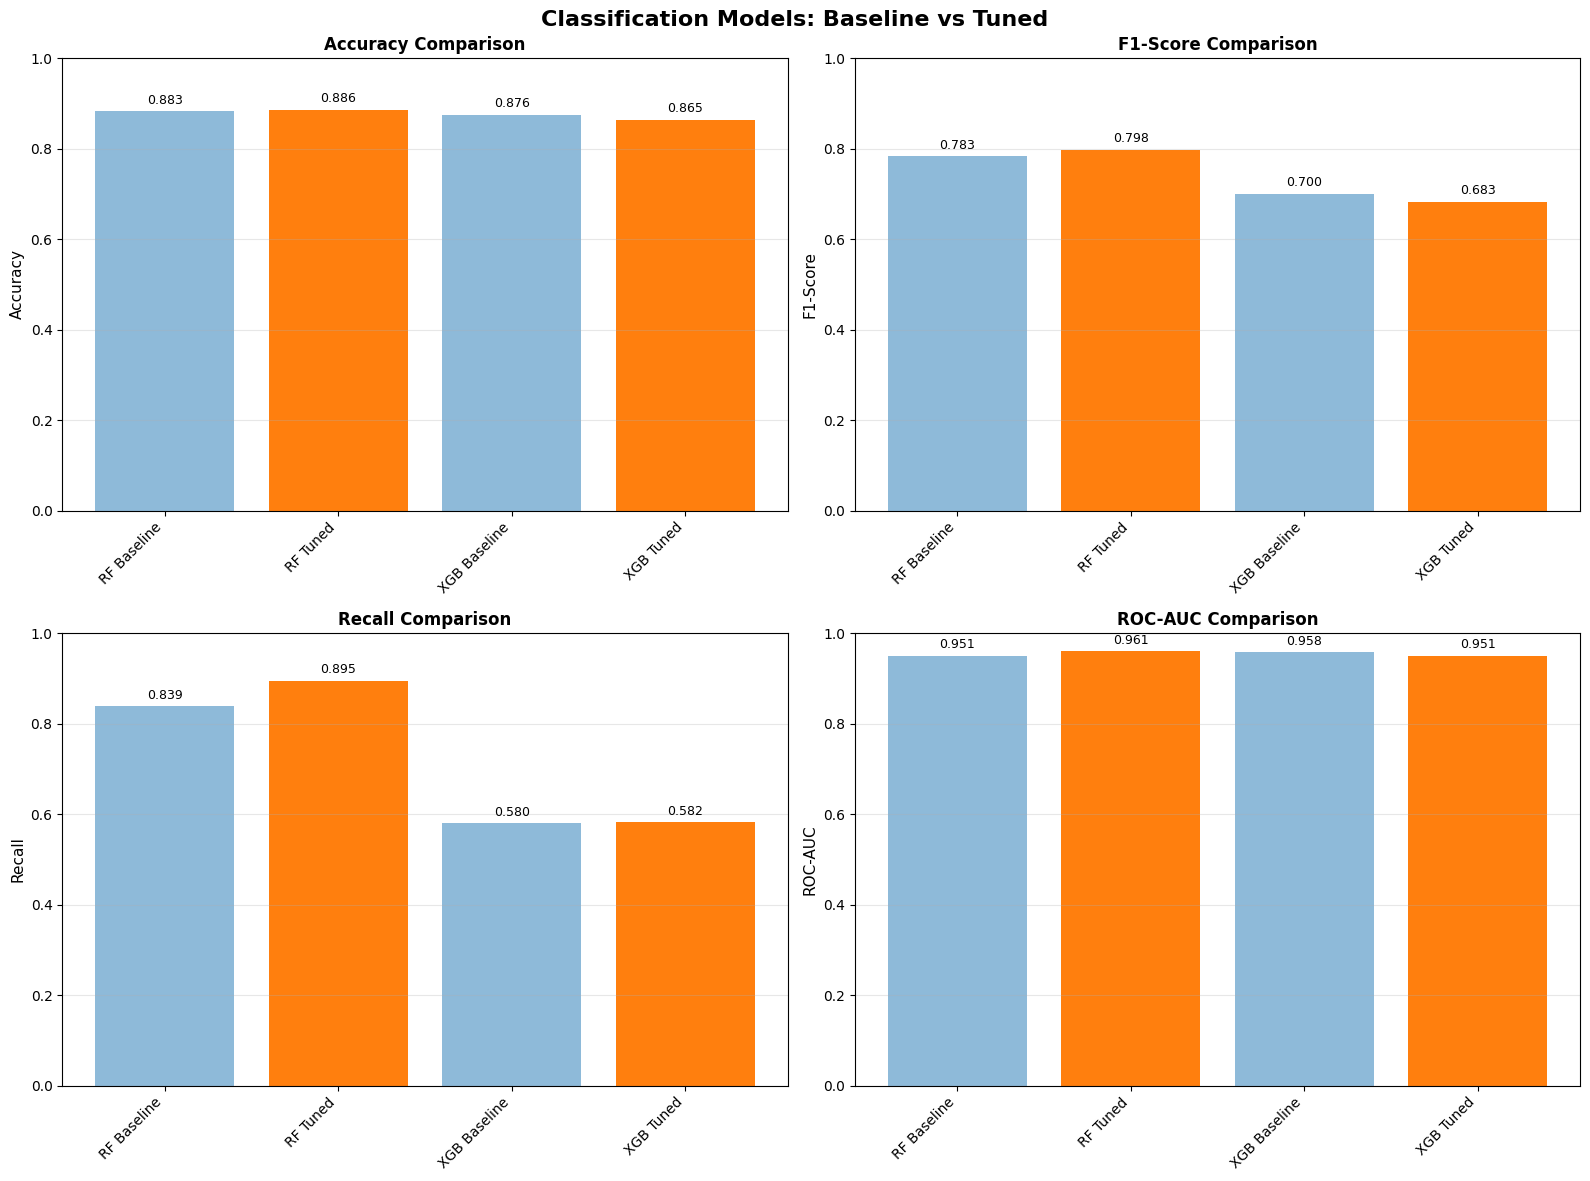

📊 Regression visualization saved: tuning_regression_comparison.png


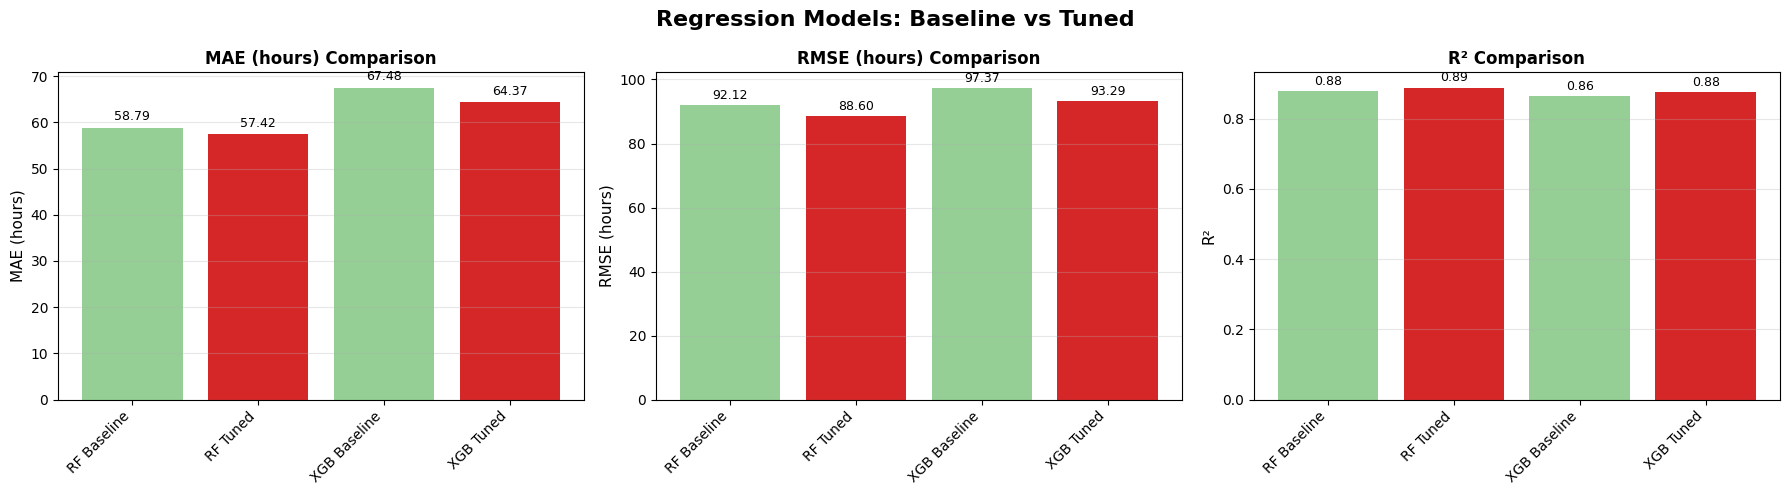


📈 TUNING IMPROVEMENTS SUMMARY

🔵 CLASSIFICATION:
   Random Forest:  F1 0.7830 → 0.7981 (+1.51%)
   XGBoost:        F1 0.7005 → 0.6832 (-1.72%)

🟢 REGRESSION:
   Random Forest:  MAE 58.79h → 57.42h (+1.37h)
   XGBoost:        MAE 67.48h → 64.37h (+3.10h)


In [9]:
# ============================================================================
# COMPREHENSIVE COMPARISON: BASELINE VS TUNED
# ============================================================================

print("\n" + "="*80)
print("FINAL COMPARISON: BASELINE VS TUNED MODELS")
print("="*80)

# ========== CLASSIFICATION COMPARISON ==========
print("\n📊 CLASSIFICATION MODELS:")

classification_comparison = pd.DataFrame({
    'Model': ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned', 
              'LR Tuned', 'Linear SVM Tuned'],
    'Accuracy': [
        baseline_scores['RF_Classifier']['test_accuracy'],
        rf_clf_results['test_accuracy'],
        baseline_scores['XGB_Classifier']['test_accuracy'],
        xgb_clf_results['test_accuracy'],
        linear_results['Logistic Regression']['test_accuracy'],
        linear_results['Linear SVM']['test_accuracy']
    ],
    'F1-Score': [
        baseline_scores['RF_Classifier']['test_f1'],
        rf_clf_results['test_f1'],
        baseline_scores['XGB_Classifier']['test_f1'],
        xgb_clf_results['test_f1'],
        linear_results['Logistic Regression']['test_f1'],
        linear_results['Linear SVM']['test_f1']
    ],
    'Recall': [
        baseline_scores['RF_Classifier']['test_recall'],
        rf_clf_results['test_recall'],
        baseline_scores['XGB_Classifier']['test_recall'],
        xgb_clf_results['test_recall'],
        recall_score(y_class_test, lr_pred),
        recall_score(y_class_test, svm_pred)
    ],
    'ROC-AUC': [
        baseline_scores['RF_Classifier']['test_roc_auc'],
        rf_clf_results['test_roc_auc'],
        baseline_scores['XGB_Classifier']['test_roc_auc'],
        xgb_clf_results['test_roc_auc'],
        linear_results['Logistic Regression']['test_roc_auc'],
        linear_results['Linear SVM']['test_roc_auc']
    ]
})

print(classification_comparison.to_string(index=False))

# ========== REGRESSION COMPARISON ==========
print("\n📊 REGRESSION MODELS:")

regression_comparison = pd.DataFrame({
    'Model': ['RF Baseline', 'RF Tuned', 'XGB Baseline', 'XGB Tuned',
              'LinReg Tuned', 'Linear SVR Tuned'],
    'MAE (hours)': [
        baseline_scores['RF_Regressor']['test_mae'],
        rf_reg_results['test_mae'],
        baseline_scores['XGB_Regressor']['test_mae'],
        xgb_reg_results['test_mae'],
        linear_results['Linear Regression']['test_mae'],
        linear_results['Linear SVR']['test_mae']
    ],
    'RMSE (hours)': [
        baseline_scores['RF_Regressor']['test_rmse'],
        rf_reg_results['test_rmse'],
        baseline_scores['XGB_Regressor']['test_rmse'],
        xgb_reg_results['test_rmse'],
        linear_results['Linear Regression']['test_rmse'],
        linear_results['Linear SVR']['test_rmse']
    ],
    'R²': [
        baseline_scores['RF_Regressor']['test_r2'],
        rf_reg_results['test_r2'],
        baseline_scores['XGB_Regressor']['test_r2'],
        xgb_reg_results['test_r2'],
        linear_results['Linear Regression']['test_r2'],
        linear_results['Linear SVR']['test_r2']
    ]
})

print(regression_comparison.to_string(index=False))

# Save comparison results
classification_comparison.to_csv('tuning_classification_comparison.csv', index=False)
regression_comparison.to_csv('tuning_regression_comparison.csv', index=False)
print("\n💾 Comparison tables saved!")

# ========== VISUALIZATION: CLASSIFICATION ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Classification Models: Baseline vs Tuned', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1-Score', 'Recall', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Filter for main models only
    plot_data = classification_comparison[
        classification_comparison['Model'].isin(['RF Baseline', 'RF Tuned', 
                                                 'XGB Baseline', 'XGB Tuned'])
    ]
    
    x = np.arange(len(plot_data))
    colors = ['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e']
    alphas = [0.5, 1.0, 0.5, 1.0]

    # Create bars individually with different alpha values
    bars = []
    for i in range(len(plot_data)):
        bar = ax.bar(x[i], plot_data[metric].iloc[i], 
                     color=colors[i], alpha=alphas[i], width=0.8)
        bars.extend(bar)
    
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('tuning_classification_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Classification visualization saved: tuning_classification_comparison.png")
plt.show()

# ========== VISUALIZATION: REGRESSION ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Regression Models: Baseline vs Tuned', fontsize=16, fontweight='bold')

reg_metrics = ['MAE (hours)', 'RMSE (hours)', 'R²']

for idx, metric in enumerate(reg_metrics):
    ax = axes[idx]
    
    plot_data = regression_comparison[
        regression_comparison['Model'].isin(['RF Baseline', 'RF Tuned',
                                             'XGB Baseline', 'XGB Tuned'])
    ]
    
    x = np.arange(len(plot_data))
    colors = ['#2ca02c', '#d62728', '#2ca02c', '#d62728']
    alphas = [0.5, 1.0, 0.5, 1.0]

    # Create bars individually with different alpha values
    bars = []
    for i in range(len(plot_data)):
        bar = ax.bar(x[i], plot_data[metric].iloc[i], 
                     color=colors[i], alpha=alphas[i], width=0.8)
        bars.extend(bar)
    
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (1 if idx < 2 else 0.01),
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('tuning_regression_comparison.png', dpi=300, bbox_inches='tight')
print("📊 Regression visualization saved: tuning_regression_comparison.png")
plt.show()

# ========== IMPROVEMENT SUMMARY ==========
print("\n" + "="*80)
print("📈 TUNING IMPROVEMENTS SUMMARY")
print("="*80)

print("\n🔵 CLASSIFICATION:")
print(f"   Random Forest:  F1 {baseline_scores['RF_Classifier']['test_f1']:.4f} → "
      f"{rf_clf_results['test_f1']:.4f} ({rf_clf_results['improvement_f1']:+.2f}%)")
print(f"   XGBoost:        F1 {baseline_scores['XGB_Classifier']['test_f1']:.4f} → "
      f"{xgb_clf_results['test_f1']:.4f} ({xgb_clf_results['improvement_f1']:+.2f}%)")

print("\n🟢 REGRESSION:")
print(f"   Random Forest:  MAE {baseline_scores['RF_Regressor']['test_mae']:.2f}h → "
      f"{rf_reg_results['test_mae']:.2f}h ({rf_reg_results['improvement_mae']:+.2f}h)")
print(f"   XGBoost:        MAE {baseline_scores['XGB_Regressor']['test_mae']:.2f}h → "
      f"{xgb_reg_results['test_mae']:.2f}h ({xgb_reg_results['improvement_mae']:+.2f}h)")

In [10]:
# ============================================================================
# DEPLOYMENT RECOMMENDATION
# ============================================================================

print("\n" + "="*80)
print("🚀 FINAL DEPLOYMENT RECOMMENDATION")
print("="*80)

# Find best models
best_clf = classification_comparison.loc[classification_comparison['F1-Score'].idxmax()]
best_reg = regression_comparison.loc[regression_comparison['MAE (hours)'].idxmin()]

print("\n🏆 RECOMMENDED MODELS FOR DEPLOYMENT:")

print(f"\n   CLASSIFICATION:")
print(f"      Model: {best_clf['Model']}")
print(f"      Accuracy: {best_clf['Accuracy']:.4f} ({best_clf['Accuracy']*100:.2f}%)")
print(f"      F1-Score: {best_clf['F1-Score']:.4f}")
print(f"      Recall: {best_clf['Recall']:.4f} (delayed voyage detection)")
print(f"      ROC-AUC: {best_clf['ROC-AUC']:.4f}")
print(f"      → FILE: model_rf_classification_tuned.pkl" if 'RF Tuned' in best_clf['Model']
          else "      → FILE: model_xgb_classification_tuned.pkl")

print(f"\n   REGRESSION:")
print(f"      Model: {best_reg['Model']}")
print(f"      MAE: {best_reg['MAE (hours)']:.2f} hours (~{best_reg['MAE (hours)']/24:.1f} days)")
print(f"      RMSE: {best_reg['RMSE (hours)']:.2f} hours")
print(f"      R²: {best_reg['R²']:.4f} ({best_reg['R²']*100:.1f}% variance explained)")
print(f"      → FILE: model_rfr_regression_tuned.pkl" if 'RF Tuned' in best_reg['Model']
          else "      → FILE: model_xgbr_regression_tuned.pkl")

# Decision logic
print("\n📋 DEPLOYMENT DECISION LOGIC:")

clf_improvement = rf_clf_results['improvement_f1']
reg_improvement = rf_reg_results['improvement_mae']

if clf_improvement > 1.0:
    print(f"   ✅ CLASSIFICATION: Use TUNED model (+{clf_improvement:.2f}% improvement)")
else:
    print(f"   ⚠️  CLASSIFICATION: Tuning provided minimal improvement (+{clf_improvement:.2f}%)")
    print(f"      → Consider using baseline for simplicity")

if reg_improvement > 3.0:
    print(f"   ✅ REGRESSION: Use TUNED model (-{reg_improvement:.2f}h improvement)")
else:
    print(f"   ⚠️  REGRESSION: Tuning provided minimal improvement (-{reg_improvement:.2f}h)")
    print(f"      → Consider using baseline for simplicity")

# Save deployment info
deployment_info = {
    'classification_model': best_clf['Model'],
    'classification_file': 'model_rf_classification_tuned.pkl' if 'RF' in best_clf['Model']
                           else 'model_xgb_classification_tuned.pkl',
    'classification_metrics': {
        'accuracy': float(best_clf['Accuracy']),
        'f1': float(best_clf['F1-Score']),
        'recall': float(best_clf['Recall']),
        'roc_auc': float(best_clf['ROC-AUC'])
    },
    'regression_model': best_reg['Model'],
    'regression_file': 'model_rfr_regression_tuned.pkl' if 'RF' in best_reg['Model']
                       else 'model_xgbr_regression_tuned.pkl',
    'regression_metrics': {
        'mae': float(best_reg['MAE (hours)']),
        'rmse': float(best_reg['RMSE (hours)']),
        'r2': float(best_reg['R²'])
    },
    'tuning_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('deployment_recommendation.pkl', 'wb') as f:
    pickle.dump(deployment_info, f)

print("\n💾 Deployment information saved: deployment_recommendation.pkl")


🚀 FINAL DEPLOYMENT RECOMMENDATION

🏆 RECOMMENDED MODELS FOR DEPLOYMENT:

   CLASSIFICATION:
      Model: RF Tuned
      Accuracy: 0.8864 (88.64%)
      F1-Score: 0.7981
      Recall: 0.8953 (delayed voyage detection)
      ROC-AUC: 0.9605
      → FILE: model_rf_classification_tuned.pkl

   REGRESSION:
      Model: RF Tuned
      MAE: 57.42 hours (~2.4 days)
      RMSE: 88.60 hours
      R²: 0.8878 (88.8% variance explained)
      → FILE: model_rfr_regression_tuned.pkl

📋 DEPLOYMENT DECISION LOGIC:
   ✅ CLASSIFICATION: Use TUNED model (+1.51% improvement)
   ⚠️  REGRESSION: Tuning provided minimal improvement (-1.37h)
      → Consider using baseline for simplicity

💾 Deployment information saved: deployment_recommendation.pkl
